In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import math
import sys, os, glob, re, time
import numpy as np
import csv
from collections import Counter
import pickle
import gc
import datetime
import pandas as pd
# import numpy as np
# import networkx as nx
import matplotlib.pyplot as plt
import datetime
from datetime import date, timedelta
from dateutil import parser
# import keras
# import time
# from keras.models import Sequential
# from keras.layers import Activation, Dense, Flatten
# from keras.layers import LSTM
# from keras.layers import Dropout
import psycopg2
from sshtunnel import SSHTunnelForwarder
import community
def shrinkData(df):
    df_int = df.select_dtypes(include=['int'])
    df_int = df_int.apply(pd.to_numeric,downcast='unsigned')
    df_float = df.select_dtypes(include=['float'])
    df_float = df_float.apply(pd.to_numeric,downcast='float')
    df['date'] = pd.to_datetime(df['date'])
    cols = df.columns[df.dtypes.eq(object)]
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce', axis=0)
    return df

def query_to_DataFrame(sqlString):
    with SSHTunnelForwarder(
        ('67.240.57.228', 22),
        #ssh_private_key="</path/to/private/ssh/key>",
        ### in my case, I used a password instead of a private key
        ssh_username="root",
        ssh_password="b3110cFr13nd", 
        remote_bind_address=('localhost', 5432)) as server:

        server.start()
        print("server connected")

        params = {
         'database': 'Prices',
         'user': 'analyst',
         'password': 'st4rg4z3r',
         'host': 'localhost',
         'port': server.local_bind_port
         }

        conn = psycopg2.connect(**params)
        curs = conn.cursor()
        print("database connected")
        # Get a database cursor
        cur = conn.cursor()

        # Execute SQL
        cur.execute(sqlString)
    #     colnames = [desc.name for desc in curs.description] 
#         print("description is :", cur.description)
        # Get the result
        result = cur.fetchall()
        colnames = [desc[0] for desc in cur.description]
        frame = shrinkData(pd.DataFrame(result, columns=colnames))
    #     print(result)

        # Close connections
        conn.close()

        # Stop the tunnel
        server.stop()
        return frame
    
def merge_data(a, b, from_date='2018-01-01'):
    """
    a: first DataFrame
    b: second DataFrame
    from_date: includes the data from the provided date and drops the any data before that date.
    returns merged data as Pandas DataFrame
    """
    merged_data = pd.merge(a, b, on=['Date'])
    merged_data = merged_data[merged_data['Date'] >= from_date]
    print("Merged")
    return merged_data
# reads tsv edge list where each line is in the format "leftnode rightnode"
# assumes file header contains 'sym' for undirected graph and 'asym' for directed graphs
def convert_tsv_to_graphml(filename):
    m = re.search("(.*)\.tsv", filename)
    name = m.group(1)
    file = open(filename, 'rb')
    header = file.readline()
    print(header)
    if b"asym" in header:
        graph_type = nx.DiGraph()
    else:
        graph_type = nx.Graph()
    lines = [line for line in file if not line.startswith(b"%")]
    print(lines[0], lines[1],"\n")
    g = nx.read_edgelist(lines, create_using=graph_type)
    nx.write_graphml(g, name+".graphml")  
    print(filename)
    return g

def distribution(counts, attribute):
    vals, cnt = zip(*counts.items())
    
    # get rid of all negative values by bumping everything up
    if (np.array(vals) < 0).any():
        print(attribute + " had negative values but is shifted up by {} now".format(-min(vals) + 1))
        vals = np.array(vals) - min(vals) + 1
        
    if 0 in np.array(vals):
        vals = np.array(vals) + 1   # account for possible 0 values for log plot
        print(attribute + " has been shifted up by 1")
        
    fig, ax = plt.subplots()
    plt.scatter(vals, cnt, color='b')
    
    plt.title(attribute + " Plot")
    plt.ylabel("Count")
    plt.xlabel(attribute)
    plt.yscale('log')
    # clustering coefficient only has log plot, not log log
    if attribute == "Clustering Coefficient":
        plt.xscale('linear')
        log_vals = np.log10(vals)
    else:
        plt.xscale('log')
        log_vals = np.log10(vals)
    
    #deg = np.log10(np.array(deg))
    #cnt = np.log10(np.array(cnt))
    vals = np.array(vals)
    cnt = np.array(cnt)
    log_vals = np.log10(vals)
    log_cnt = np.log10(cnt)
    
    m, b = np.polyfit(log_vals, log_cnt, 1)
    y_fit = np.power(10, m*log_vals + b)
    #plt.plot(deg, cnt, '.')
    plt.plot(vals, y_fit , '-')
    
# This will read in the correlation TSV file and create the graphML file to disk
def make_currency_graph(filename, name):
    corr = np.genfromtxt(fname=filename, delimiter='\t',dtype=float, names=True)    # fname="correlations.tsv"
    corrGraph = nx.Graph()
    names = corr.dtype.names
    
    for i in range(len(corr)):
        l_node = names[i]
        l_type = l_node.split("_")[-1]
        l_name = l_node.split("_")[0]
        
        for j in range(i + 1, len(corr)):
            r_node = names[j]
            
            if i == 0:
                r_type = r_node.split("_")[-1]
                r_name = r_node.split("_")[0]
                corrGraph.add_node(l_node, position=l_type, name = l_name)
                corrGraph.add_node(r_node, position=r_type, name = r_name)
                
            corrGraph.add_edge(l_node, r_node, weight = float(corr[i][j]))
    
    corrGraph.name = name
    corrGraph = nx.maximum_spanning_tree(corrGraph)
    nx.write_graphml(corrGraph, corrGraph.name + ".graphml")

    return corrGraph

def createGraphFiles(filename, name):
    graphs = []
    g = make_currency_graph(filename, name)
    print("Creating graphml file for", g.name)
    print("Graph name is", g.name)

    # Create or retrieve Erdos-Renyi random graph
    if not os.path.exists(g.name + "_ER.graphml"):
        print("Creating ER graph for " + g.name + " from scratch")
        k = 2 * g.number_of_edges() / g.number_of_nodes()   # average degree

 
        print("For currencies, use weighted degree for ER")
        edges_dict = g.edges()
        k = sum([edges_dict[edge]["weight"] for edge in edges_dict]) * 2 / g.number_of_nodes()

        p = k / (g.number_of_nodes() - 1)                  # probability = avg deg / # of possible neighbors (n-1)
        g_ER = nx.generators.erdos_renyi_graph(g.number_of_nodes(), p)
        nx.write_graphml(g_ER, g.name+"_ER.graphml")
    else:
        print("Reading in the ER graphml file for " + g.name)
        g_ER = nx.read_graphml(g.name+"_ER.graphml")
    g_ER.name = g.name + "_ER"

    # Create or retrieve Barabasi-Albert scale-free network
    if not os.path.exists(g.name + "_BA.graphml"):
        print("Creating BA graph for " + g.name + " from scratch")
        m = 1
        n = g.number_of_nodes()
        g_BA = nx.generators.barabasi_albert_graph(n, m)
        old_dist = abs(g.number_of_edges() - g_BA.number_of_edges())

        # increment m until it generates the BA graph closest to real graph also make sure m never equals n
        while g_BA.number_of_edges() < g.number_of_edges() and m + 1 < n:
            m += 1
            old_dist = abs(g.number_of_edges() - g_BA.number_of_edges())
            g_BA = nx.generators.barabasi_albert_graph(n, m)

        # See how close our graph is to the original and decrement m by 1 if we've gone too far    
        dist = abs(g_BA.number_of_edges() - g.number_of_edges())
        if old_dist < dist:
            g_BA = nx.generators.barabasi_albert_graph(n, m - 1)
            print("Use previous m value:", m - 1)
        else:
            print("Use current m value:", m)

        nx.write_graphml(g_BA, g.name + "_BA.graphml")
    else:
        print("Reading in the BA graphml file for " + g.name)
        g_BA = nx.read_graphml(g.name+"_BA.graphml")
    g_BA.name = g.name + "_BA"    

    graphs += [g, g_ER, g_BA]
    return graphs

def analyzeGraphs(graphs):
    # Now loop through all of our graphs
    i = 1
    for g in graphs:

        graph_name = g.name

        # if we haven't generated the CSV files yet, cut the program off and prompt the user to do so
        if not os.path.exists(graph_name + ".csv"):
            print("We are missing the CSV file of statistics '{}'".format(graph_name + ".csv"))
            print("Now run Gephi statistics on the created GraphML files and export as CSV, then rerun this program")
            continue

        print("\nReading the graph metrics from '" + graph_name + "'.csv")

        statFilCSV = open(graph_name + ".csv", 'r')
        headFile = open(graph_name + ".csv", 'r')
        header = next(csv.reader(headFile))
        headFile.close()

        reader = csv.DictReader(statFilCSV)
        network_stats = {attribute: [] for attribute in header}
        counters = {}

        # Get raw network statistics from CSV Gephi output
        for row in reader:
            Id, label, timeset, eccentricity, closnesscentrality, harmonicclosnesscentrality, betweenesscentrality, componentnumber, degree, clustering, triangles, eigencentrality, weightedDegree \
            = row["Id"], row["Label"],	row["timeset"],	int(row["Eccentricity"]),	float(row["closnesscentrality"]),	float(row["harmonicclosnesscentrality"]),	float(row["betweenesscentrality"]),	int(row["componentnumber"]),	int(row["Degree"]),	float(row["clustering"]),	int(row["triangles"]),	float(row["eigencentrality"]),	float(row["Weighted Degree"])
            network_stats["clustering"].append(clustering)
            network_stats["betweenesscentrality"].append(betweenesscentrality)
            network_stats["Degree"].append(degree)
            network_stats["closnesscentrality"].append(closnesscentrality)
            network_stats["componentnumber"].append(componentnumber)
            network_stats["Weighted Degree"].append(weightedDegree)

        # Get distribution of network statistics
        counters["Degree"] = Counter(sorted(network_stats["Degree"]))
        counters["clustering"] = Counter(sorted(network_stats["clustering"]))
        counters["betweenesscentrality"] = Counter(sorted(network_stats["betweenesscentrality"]))
        counters["closnesscentrality"] = Counter(sorted(network_stats["closnesscentrality"]))
        counters["componentnumber"] = Counter(sorted(network_stats["componentnumber"]))
        counters["Weighted Degree"] = Counter(sorted(network_stats["Weighted Degree"]))

        components = nx.connected_component_subgraphs(g)
        components = sorted(components, key=len, reverse=True)
        network_stats["componentsize"] = [len(comp) for comp in components]
        cc = Counter(network_stats["componentsize"])
        gc = components[0]
        print("Size of largest connected component:", len(gc))
        counters["componentsize"] = cc

        plt.figure(i)
        i += 1

        distribution(counters["Degree"], "Degree")
        plt.suptitle(graph_name)
        if not os.path.exists(graph_name+"-Degree.png"):
            plt.savefig(graph_name+"-Degree.png")
            print("Saving {}-Degree.png".format(graph_name))

        if "currencyCorrelations" in graph_name:
            distribution(counters["Weighted Degree"], "Weighted Degree")
            plt.suptitle(graph_name)
            if not os.path.exists(graph_name+"-WeightedDegree.png"):
                plt.savefig(graph_name+"-WeightedDegree.png")
                print("Saving {}-WeightedDegree.png".format(graph_name))

        if len(set(network_stats["clustering"])) > 1:
            distribution(counters["clustering"], "Clustering Coefficient")
            plt.suptitle(graph_name)
            if not os.path.exists(graph_name+"-ClusteringCoefficient.png"):
                plt.savefig(graph_name+"-ClusteringCoefficient.png")
                print("Saving {}-ClusteringCoefficient.png".format(graph_name))

        if len(set(network_stats["betweenesscentrality"])) > 1:
            distribution(counters["betweenesscentrality"], "Betweeness Centrality")
            plt.suptitle(graph_name)
            if not os.path.exists(graph_name+"-BetweenessCentrality.png"):
                plt.savefig(graph_name+"-BetweenessCentrality.png")
                print("Saving {}-BetweenessCentrality.png".format(graph_name))

        if len(set(network_stats["componentnumber"])) > 1:
            distribution(counters["componentsize"], "Connected Components Size")
            plt.suptitle(graph_name)
            if not os.path.exists(graph_name+"-ConnectedComponents.png"):
                plt.savefig(graph_name+"-ConnectedComponents.png")
                print("Saving {}-ConnectedComponents.png".format(graph_name))

        plt.show()

        print("\nAverage Values:")
        print("\tAverage Degree: {} weighted, {} unweighted".format(np.mean(network_stats["Degree"]), np.mean(network_stats["Weighted Degree"])))
        print("\tAverage Clustering Coefficient:", np.mean(network_stats["clustering"]))
        print("\tAverage Betweeness Centrality:", np.mean(network_stats["betweenesscentrality"]))
        print("\tAverage Connected Components Size:", np.mean(network_stats["componentsize"]))     # since there's only one connected component, average is # of nodes

        print("\nVariance of Values:")
        print("\tVariance of Degree: {} weighted, {} unweighted".format(np.var(network_stats["Degree"]), np.var(network_stats["Weighted Degree"])))
        print("\tVariance of Clustering Coefficient:", np.var(network_stats["clustering"]))
        print("\tVariance of Betweeness Centrality:", np.var(network_stats["betweenesscentrality"]))
        print("\tVariance of Connected Components Size:", np.var(network_stats["componentsize"]))     # since there's only one connected component, variance is 0


        print("Average Closeness Centrality:", np.mean(network_stats["closnesscentrality"]))
        statFilCSV.close()

In [ ]:
aggregateQuery = "SELECT * FROM Prices.aggregates WHERE date >= '2018-01-01';"
aggregateframe = query_to_DataFrame(aggregateQuery)

In [ ]:
indexes = ['GSPC', 'DJI', 'IXIC', 'NYA', 'XAX', 'BUK100P', 'RUT', 'VIX', 'GDAXI', 'FCHI', 'STOXX50E', 'N100', 'BFX', 'HSI', 'AXJO', 'JKSE', 'NZ50', 'KS11', 'TWII', 'GSPTSE', 'BVSP', 'MXX', 'IPSA', 'MERV', 'TA125TA', 'JN0UJO']
instruments = ['COPPERCMDUSD', 'GASCMDUSD', 'LIGHTCMDUSD', 'BRENTCMDUSD', 'DIESELCMDUSD', 'XAUUSD', 'XAGUSD', 'GBPUSD', 'NZDUSD', 'USDCAD', 'USDJPY', 'USDCHF', 'USDCAD', 'GBPUSD', 'EURUSD', 'AUDUSD', 'XAGUSD', 'XAUUSD', 'DIESELCMDUSD', 'BRENTCMDUSD', 'LIGHTCMDUSD', 'GASCMDUSD', 'AUDCAD', 'AUDCHF', 'AUDJPY', 'AUDNZD', 'AUDSGD', 'CADCHF', 'CADHKD', 'CADJPY', 'CHFJPY', 'CHFSGD', 'EURAUD', 'EURCAD', 'EURCHF', 'EURCZK', 'EURDKK', 'EURGBP', 'EURHKD', 'EURHUF', 'EURJPY', 'EURNOK', 'EURNZD', 'EURPLN', 'EURRUB', 'EURSEK', 'EURSGD', 'EURTRY', 'GBPAUD', 'GBPCAD', 'GBPCHF', 'GBPJPY', 'GBPNZD', 'HKDJPY', 'NZDCAD', 'NZDCHF', 'NZDJPY', 'SGDJPY', 'TRYJPY', 'USDCNH', 'USDCZK', 'USDDKK', 'USDHUF', 'USDILS', 'USDMXN', 'USDNOK', 'USDPLN', 'USDRON', 'USDRUB', 'USDSEK', 'USDSGD', 'USDTHB', 'USDTRY', 'USDZAR', 'ZARJPY']
nameList = ['Dates']
instruments = list(set(instruments))
indexes = list(set(indexes))

In [ ]:
### Separate Stocks and Currencies

indexSection = (len(indexes) * 6)+1
StockIndexes = aggregateframe

StockIndexes = StockIndexes.drop(columns=aggregateframe.columns[indexSection:])
StockIndexes.head()

currencies = aggregateframe
currencies = currencies.drop(columns=aggregateframe.columns[1:indexSection])
currencies.head()

In [ ]:
## Organize Currency Data

a = currencies.columns[currencies.columns.str.endswith('avg')]
a = a.insert(0,'date')
averages = currencies[a]
averages.head()

a = currencies.columns[currencies.columns.str.endswith('high')]
a = a.insert(0,'date')
highCurr = currencies[a]
highCurr.head()

a = currencies.columns[currencies.columns.str.endswith('low')]
a = a.insert(0,'date')
lowCurr = currencies[a]
lowCurr.head()

In [ ]:
a = StockIndexes.columns[StockIndexes.columns.str.endswith('open')]
a = a.insert(0,'date')
opens = StockIndexes[a]
opens.head()

a = StockIndexes.columns[StockIndexes.columns.str.endswith('close')]
a = a.insert(0,'date')
closes = StockIndexes[a]
closes.head()

a = StockIndexes.columns[StockIndexes.columns.str.endswith('high')]
a = a.insert(0,'date')
highStk = StockIndexes[a]
highStk.head()

a = StockIndexes.columns[StockIndexes.columns.str.endswith('low')]
a = a.insert(0,'date')
lowStk = StockIndexes[a]
lowStk.head()

a = StockIndexes.columns[StockIndexes.columns.str.endswith('adjclose')]
a = a.insert(0,'date')
adjclose = StockIndexes[a]
opens.head()

a = StockIndexes.columns[StockIndexes.columns.str.endswith('volume')]
a = a.insert(0,'date')
volumes = StockIndexes[a]
volumes.head()

a = aggregateframe.columns[aggregateframe.columns.str.endswith('high')]
a = a.insert(0,'date')
highAll = aggregateframe[a]
highAll.head()

In [ ]:
a = aggregateframe.columns[aggregateframe.columns.str.endswith('low')]
a = a.insert(0,'date')
lowAll = aggregateframe[a]
lowAll.head()

In [ ]:
def get_market_data(market, tag=True):
    market_data = pd.read_html("https://coinmarketcap.com/currencies/" + market + 
                                 "/historical-data/?start=20180101&end="+time.strftime("%Y%m%d"), flavor='html5lib')[0]
    market_data = market_data.rename(columns={'Date':'date'})
    market_data = market_data.assign(Date=pd.to_datetime(market_data['date']))
    market_data['Volume'] = (pd.to_numeric(market_data['Volume'], errors='coerce').fillna(0))
    if tag:
        market_data.columns = [market_data.columns[0]] + [tag + '_' + i for i in market_data.columns[1:]]
    return market_data

In [ ]:
### Get and Organize CryptoCurrency Data


cointags = [ ('bitcoin', 'BTC'), ('ripple', 'XRP'), ('ethereum', 'ETH'), ('stellar', 'XLM'), 
           ('eos', 'EOS'), ('litecoin', 'LTC'), ('tether', 'USDT'), ('cardano', 'ADA'), ('monero', 'XMR'),
            ('tron', 'TRX'), ('iota', 'MIOTA'), ('dash', 'DASH'), ('bitcoin-cash', 'BCH'), ('binance-coin','BNB')]
coinframes =[]
for tag in cointags:
    print(tag)
    frame = shrinkData(get_market_data(tag[0],tag[1]))
    frame = frame.drop(columns=tag[1]+'_Date')
    coinframes.append(frame)
    coinframes[-1].rename(columns={tag[1]+'_Open*': tag[1]+'_Open', tag[1]+'_Close**':tag[1]+'_Close'}, inplace=True)
    
coins = coinframes[0]
for i in range(1, len(coinframes)):
    coins = pd.merge(coins, coinframes[i], on=['date'])
    

a = coins.columns[coins.columns.str.endswith('Open')]
a = a.insert(0,'date')
opensCoins = coins[a]
opensCoins.head()

a = coins.columns[coins.columns.str.endswith('Close')]
a = a.insert(0,'date')
closesCoins = coins[a]
closesCoins.head()

a = coins.columns[coins.columns.str.endswith('High')]
a = a.insert(0,'date')
highCoins = coins[a]
highCoins.head()

a = coins.columns[coins.columns.str.endswith('Low')]
a = a.insert(0,'date')
lowCoins = coins[a]
lowCoins.head()


a = coins.columns[coins.columns.str.endswith('Volume')]
a = a.insert(0,'date')
volumesCoins = coins[a]
volumesCoins.head()

In [ ]:
all_Highs = pd.merge(highStk, highCurr, on=['date'])
all_Highs = pd.merge(all_Highs, highCoins, on=['date'])

all_Lows = pd.merge(lowStk, lowCurr, on=['date'])
all_Lows = pd.merge(all_Lows, lowCoins, on=['date'])

In [58]:
def graphinate(dataframe, name):
    correlations = aggregateframe.corr()
    correlations.to_csv('currencyCorrelations.tsv', sep='\t', encoding='utf-8', index=False)
    G = make_currency_graph('correlations.tsv', name)
    return G

In [59]:

G = graphinate(all_Highs, 'All High-Peak Values')

NameError: name 'convert_sort' is not defined

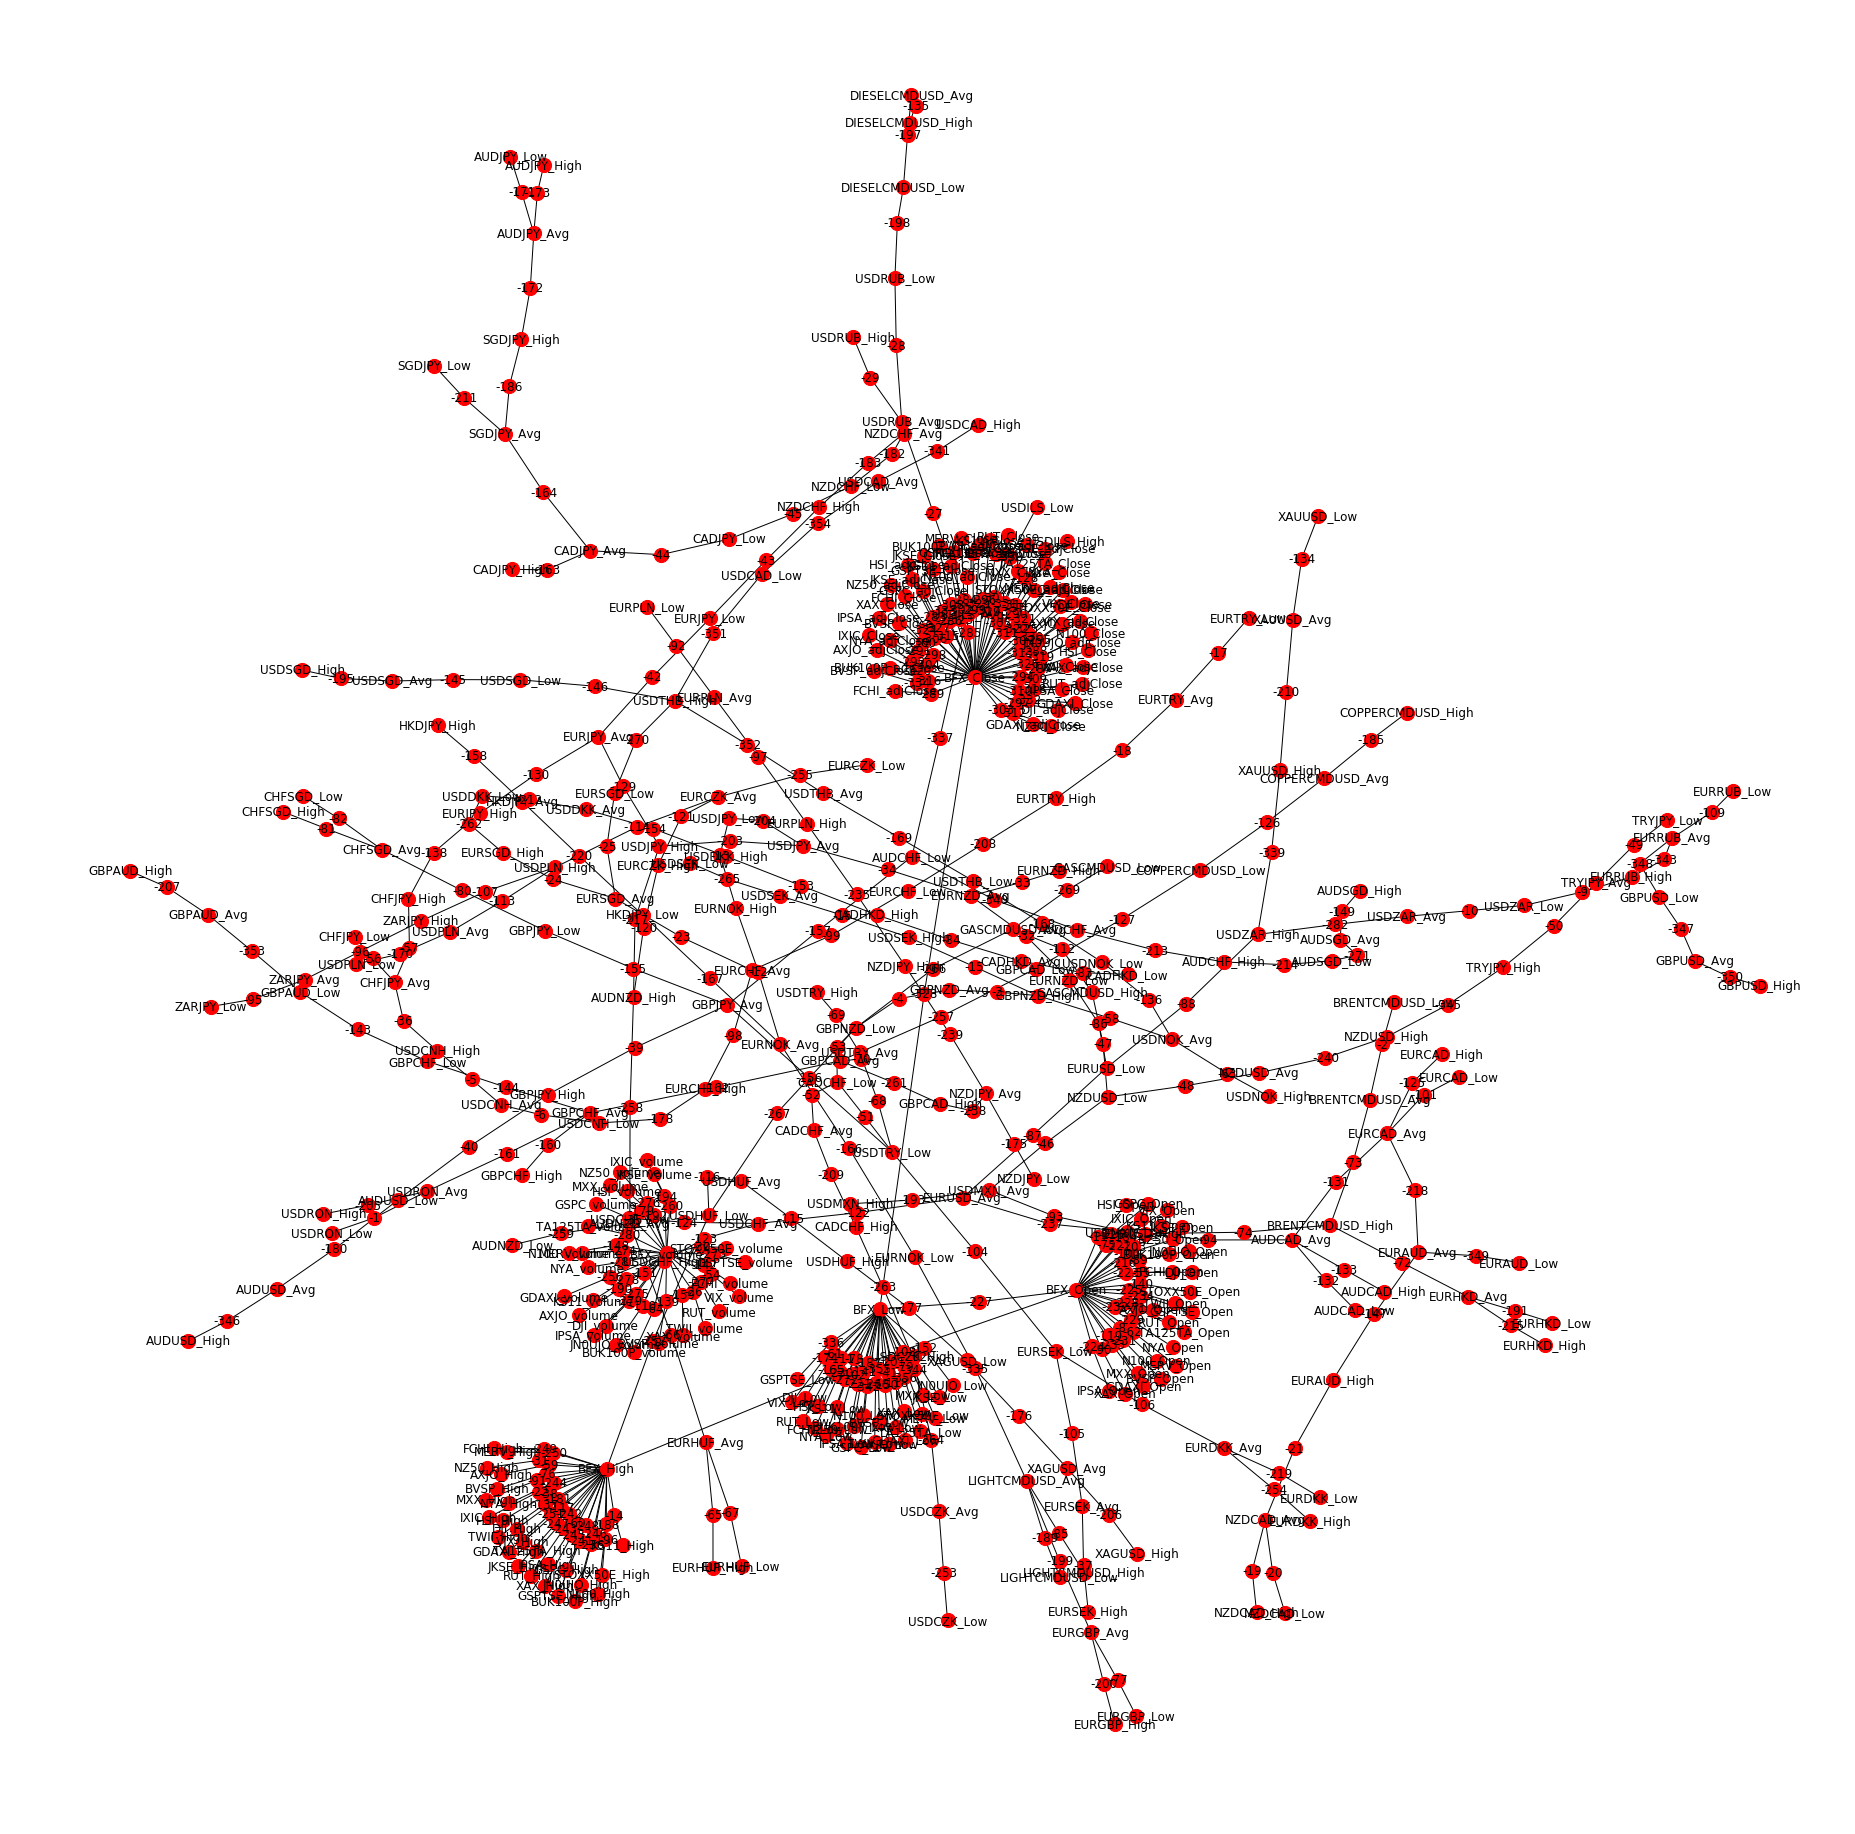

In [60]:
#### This Cell implements some clique based functions
part = list(nx.algorithms.clique.find_cliques(G))
part2 = nx.graph_number_of_cliques(G, cliques=None)
part3  = list(nx.algorithms.clique.enumerate_all_cliques(G))
bipart = nx.algorithms.clique.make_clique_bipartite(G, fpos=None, create_using=None, name=None)
# part = convert_sort(part)
# values = [part.get(node) for node in G.nodes()]
plt.figure(figsize=(25,25))
nx.draw_spring(bipart, cmap = plt.get_cmap('jet'),  node_size=200, with_labels=True)
part = convert_sort(part)
values = [part.get(node) for node in G.nodes()]
plt.figure(figsize=(25,25))
nx.draw_spring(G, cmap = plt.get_cmap('jet'), node_color = values, node_size=200, with_labels=True)